In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import datetime

# setup
- seed
- TensorBoard
- config

In [2]:
from dataclasses import dataclass

@dataclass
class Config:
    # fixed seed
    seed = 111
    batch_size: int = 256
    # -1 to use all data
    dataset_size: int = -1
    # load the checkpoint from the start_epoch
    start_epoch: int = 0
    n_epochs: int = 1000
    lr: float = 0.0001

    relu_slope: float = 0.2
    dropout: float = 0.5
    # randn dim
    # in_dim: int = 100
    in_dim: int = 10
    # (CelebA) 218x178
    # out_dim: int = 3 * 218 * 178
    # (MNIST): 28x28
    out_dim: int = 1 * 28 * 28

    save_epoch_interval: int = 30
    exp_id: str = 'mnist_gan_exp_0616_1'

config = Config()

In [3]:
import random

random.seed((config.seed))
torch.manual_seed(config.seed)

In [4]:
def setup_tensorboard(id):
    # template = "%Y-%m-%d_%H-%M-%S"
    print(f'logdir=runs/{id}')
    writer = SummaryWriter(f'runs/{id}')
    return writer

writer = setup_tensorboard(config.exp_id)

logdir=runs/mnist_gan_exp_0616_1


## Dataset


In [5]:
def clean_cache():
    # empty cache
    torch.cuda.empty_cache()
    # print(torch.cuda.memory_summary(device=None, abbreviated=False))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


data=59904, batch_size=256, n_epochs=1000


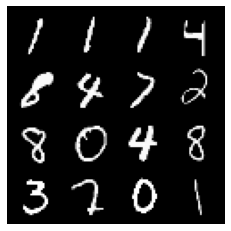

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

data = datasets.MNIST(root='./dataset', download=True, transform=transform)
# <https://stackoverflow.com/questions/70896841/error-downloading-celeba-dataset-using-torchvision>
# data = datasets.CelebA(root='./dataset', download=True, transform=transform)

# load dataset partially
if config.dataset_size > 0:
    data, _ = random_split(data, [config.dataset_size, len(data) - config.dataset_size])

dataloader = DataLoader(data, batch_size=config.batch_size, shuffle=True, drop_last=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def preview_dataset(batch):
    size = (4, 4)
    plt.figure(figsize=size)
    plt.axis("off")
    plt.imshow(np.transpose(
        vutils.make_grid(
            batch[:size[0] * size[1]],
            nrow = size[0],
            # normalize=True
        ).cpu(), (1,2,0))
    )

images, _ = next(iter(dataloader))
preview_dataset(images)
clean_cache()
print(f'data={len(dataloader) * config.batch_size}, batch_size={config.batch_size}, n_epochs={config.n_epochs}')


# Model

In [7]:
class Generator(nn.Module):
    def __init__(self, config: Config):
        super(Generator, self).__init__()
        sizes = [config.in_dim, 256, 512, 1024, config.out_dim]
        self.slope = config.relu_slope

        self.net = nn.Sequential(
            nn.Linear(sizes[0], sizes[1]),
            nn.LeakyReLU(config.relu_slope, inplace=True),

            nn.Linear(sizes[1], sizes[2]),
            nn.LeakyReLU(config.relu_slope, inplace=True),

            nn.Linear(sizes[2], sizes[3]),
            nn.LeakyReLU(config.relu_slope, inplace=True),

            nn.Linear(sizes[3], sizes[4]),
            nn.Tanh(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


class Discriminator(nn.Module):
    def __init__(self, config: Config):
        super(Discriminator, self).__init__()
        sizes = [config.out_dim, 1024, 512, 256, 1]
        self.net = nn.Sequential(
            nn.Linear(sizes[0], sizes[1]),
            nn.LeakyReLU(config.relu_slope, inplace=True),
            nn.Dropout(config.dropout),

            nn.Linear(sizes[1], sizes[2]),
            nn.LeakyReLU(config.relu_slope, inplace=True),
            nn.Dropout(config.dropout),

            nn.Linear(sizes[2], sizes[3]),
            nn.LeakyReLU(config.relu_slope, inplace=True),
            nn.Dropout(config.dropout),

            nn.Linear(sizes[3], sizes[4]),
            nn.Dropout(config.dropout),
            nn.Sigmoid(),
        )


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

In [8]:
def save_checkpoint(generator: Generator, discriminator: Discriminator, optim_generator, optim_discriminator, config: Config, epoch: int):
    print(f'save models @ epoch={epoch}')
    torch.save({
        'epoch': epoch,
        'generator': generator.state_dict(),
        'discriminator': discriminator.state_dict(),
        'optim_generator': optim_generator.state_dict(),
        'optim_discriminator': optim_discriminator.state_dict(),
    }, f'models/{config.exp_id}_{epoch}.pt')


def load_checkpoint(config: Config, start_epoch: int):
    print(f'load models @ epoch={start_epoch}')
    checkpoint = torch.load(f'models/{config.exp_id}_{start_epoch}.pt')

    config.start_epoch = checkpoint['epoch'] + 1
    generator = Generator(config).to(device)
    generator.load_state_dict(checkpoint['generator'])
    generator.train()
    discriminator = Discriminator(config).to(device)
    discriminator.load_state_dict(checkpoint['discriminator'])
    discriminator.train()

    optim_generator = optim.AdamW(generator.parameters(), lr=config.lr)
    optim_generator.load_state_dict(checkpoint['optim_generator'])
    optim_discriminator = optim.Adam(discriminator.parameters(), lr=config.lr)
    optim_discriminator.load_state_dict(checkpoint['optim_discriminator'])
    
    return generator, discriminator, optim_generator, optim_discriminator


def create_model(config: Config):
    """
    create new model etc
    """
    generator = Generator(config).to(device)
    discriminator = Discriminator(config).to(device)

    optim_generator = optim.AdamW(generator.parameters(), lr=config.lr)
    optim_discriminator = optim.AdamW(discriminator.parameters(), lr=config.lr)

    return generator, discriminator, optim_generator, optim_discriminator

def train(
    writer: SummaryWriter,
    generator: Generator, 
    discriminator: Discriminator,
    optim_generator,
    optim_discriminator,
    dataloader: DataLoader,
    config: Config,
):
    criterion = nn.BCELoss()
    print(f'criterion: {criterion}')

    for epoch in range(config.start_epoch, config.start_epoch + config.n_epochs):
        now = datetime.datetime.now
        print(f'[{now()}] Epoch {epoch}')
        for i, (x, _) in enumerate(dataloader):
            x = x.to(device).view(-1, config.out_dim)
            step = epoch * len(dataloader) + i
            z = torch.randn(config.batch_size, config.in_dim, device = device)

            # train generator
            fake = generator(z)
            fake_output = discriminator(fake)

            loss_generator = criterion(fake_output, torch.ones_like(fake_output))

            optim_generator.zero_grad()
            loss_generator.backward()
            optim_generator.step()

            # train discriminator
            z = torch.randn(config.batch_size, config.in_dim, device = device)
            real_output = discriminator(x)
            fake_output = discriminator(generator(z))
            loss_real = criterion(real_output, torch.ones_like(real_output))
            loss_fake = criterion(fake_output, torch.zeros_like(fake_output))

            loss_discriminator = (loss_real + loss_fake) / 2.

            optim_discriminator.zero_grad()
            loss_discriminator.backward()
            optim_discriminator.step()

            writer.add_scalar('loss/generator', loss_generator.item(), step)
            writer.add_scalar('loss/discriminator', loss_discriminator.item(), step)
            print(f'[{now()}] Epoch {epoch} batch {i} loss/g: {loss_generator.item():.2f} loss/d: {loss_discriminator.item():.2f}')

        # generate image
        with torch.no_grad():
            # input
            z = torch.randn(config.batch_size, config.in_dim).to(device)
            images = generator(z).view(-1, *shape)
            writer.add_images(f'generated_image', images, epoch)

        if epoch % config.save_epoch_interval == 0:
            save_checkpoint(generator, discriminator, optim_generator, optim_discriminator, config, epoch)

# Train

In [9]:
clean_cache()

# (channel, width, height)
shape = iter(dataloader).next()[0].shape[1:]
# generator, discriminator, optim_generator, optim_discriminator = load_model(config, 0)
# generator, discriminator, optim_generator, optim_discriminator = create_model(config)
# # train(writer, generator, discriminator, optim_generator, optim_discriminator, dataloader, config)

load models @ epoch=0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


load models @ epoch=30
load models @ epoch=60


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


load models @ epoch=90


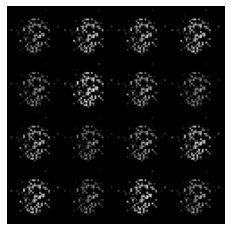

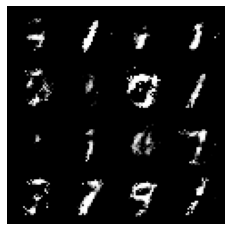

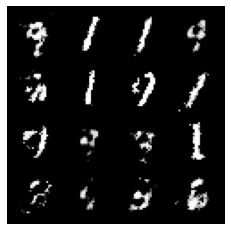

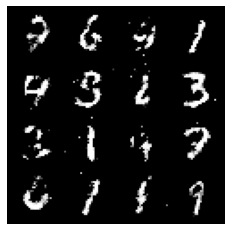

In [10]:
# preview checkpoints
for epoch in [0, 30, 60, 90]:
    generator, *_ = load_checkpoint(config, epoch)
    generator.to(device)
    shape = iter(dataloader).next()[0].shape[1:]
    z = torch.randn(config.batch_size, config.in_dim, device=device)
    images = generator(z).view(-1, *shape)
    preview_dataset(images)

# Test

「1」と判断される画像を生成するような乱数の平均値から「9」と判断される画像を生成するような乱数の平均値に線形補間をしてみる.

load models @ epoch=90


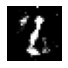

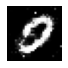

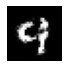

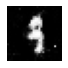

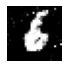

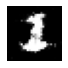

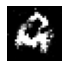

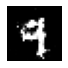

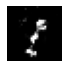

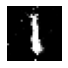

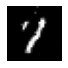

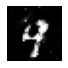

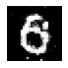

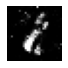

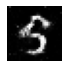

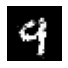

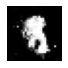

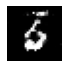

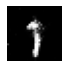

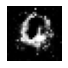

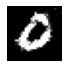

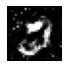

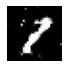

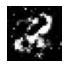

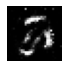

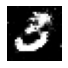

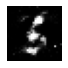

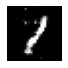

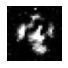

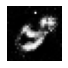

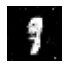

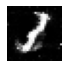

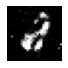

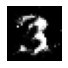

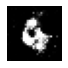

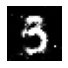

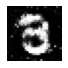

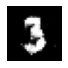

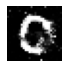

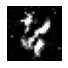

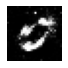

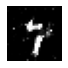

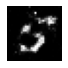

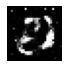

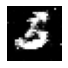

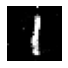

(3, 10)


In [25]:
# load model form checkpoint
generator, *_ = load_checkpoint(config, 90)
generator.to(device)
shape = iter(dataloader).next()[0].shape[1:]

plt.rcParams["figure.figsize"] = (1, 1)

def collect_zs(n1: int, n2: int, count: int):
    """
    labeling the generated images with the target label

    return: (n, in_dim)
    """
    zs_of_n1 = []
    zs_of_n2 = []
    while len(zs_of_n1) < count or len(zs_of_n2) < count:
        z = torch.randn(config.batch_size, config.in_dim, device=device)
        images = generator(z).view(-1, *shape).detach().cpu().numpy()
        image = np.transpose(images[0], (1, 2, 0))
        plt.axis('off')
        plt.imshow(image, cmap='gray')
        plt.show()

        label = input('label?')
        if int(label) == n1:
            z = z[0, :].detach().cpu().numpy()
            zs_of_n1.append(z)
        if int(label) == n2:
            z = z[0, :].detach().cpu().numpy()
            zs_of_n2.append(z)
    return np.array(zs_of_n1[:count]), np.array(zs_of_n2[:count])
cnt = 3
zs_of_1, zs_of_9 = collect_zs(1, 9, cnt)
# (n, in_dim)
print(zs_of_1.shape)

[ 0.3652788  -0.5635245   0.2839792  -0.28752914 -0.50440526  0.38499424
  0.8665433  -0.22566356  1.0558671   0.68965954]
[-0.02964481 -0.24777456 -0.28715408 -0.75992304 -0.8271515   0.19729924
  0.8692565   0.47433177  0.10300986  0.5993879 ]


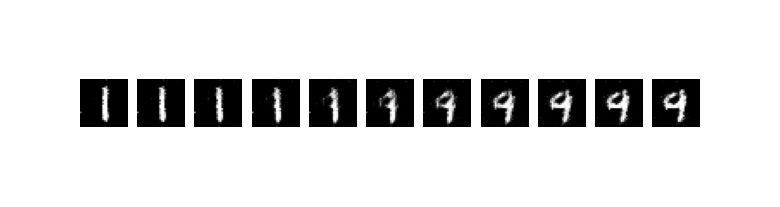

In [28]:
def morphing(z1, z2, step: int):
    """
    do morphing with [step]s
    """
    res = []
    for alpha in np.linspace(0.0, 1.0, step):
        z = torch.zeros(config.batch_size, config.in_dim, device=device)
        interp = torch.Tensor((1.0 - alpha) * z1 + alpha * z2)
        z[0, :] = interp
        # (batch_size, channel, width, height)
        out = generator(z).cpu().view(-1, *shape).detach().numpy()
        # (width, height, channel)
        image = np.transpose(out[0], (1, 2, 0))
        res.append((alpha, image))
    return res

# (in_dim)
z_of_1, z_of_9 = np.average(zs_of_1, axis=0), np.average(zs_of_9, axis=0)
print(z_of_1)
print(z_of_9)
step = 11
imgs = morphing(z_of_1, z_of_9, step)
plt.figure(figsize=(1, step), dpi=800)
for i, (alpha, image) in enumerate(imgs):
    plt.subplot(1, step, i + 1, label=f'alpha: {alpha}')
    plt.axis('off')
    plt.imshow(image, cmap='gray')
plt.show()